In [1]:
from inda_mir.modeling.models import *
from inda_mir.modeling.evaluation import *
from inda_mir.modeling.train_test_split import load_data

In [2]:
data = load_data('/Users/itallosilva/Workspace/indaband/track_classifier/output-inda/train_test_split/random_split.data')

In [3]:
X_train, y_train = data.get_numpy_train_data()
X_test, y_test = data.get_numpy_test_data()

In [4]:
data.get_features_names()

Index(['average_loudness', 'barkbands_crest_dmean', 'barkbands_crest_dmean2',
       'barkbands_crest_dvar', 'barkbands_crest_dvar2', 'barkbands_crest_max',
       'barkbands_crest_mean', 'barkbands_crest_median', 'barkbands_crest_min',
       'barkbands_crest_stdev',
       ...
       'zerocrossingrate_dmean', 'zerocrossingrate_dmean2',
       'zerocrossingrate_dvar', 'zerocrossingrate_dvar2',
       'zerocrossingrate_max', 'zerocrossingrate_mean',
       'zerocrossingrate_median', 'zerocrossingrate_min',
       'zerocrossingrate_stdev', 'zerocrossingrate_var'],
      dtype='object', length=2646)

# LightGBM

In [5]:
lgbmc = LightGBMClassifier()
lgbmc.fit(X_train, y_train)


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 668331
[LightGBM] [Info] Number of data points in the train set: 2243, number of used features: 2639
[LightGBM] [Info] Start training from score -1.529361
[LightGBM] [Info] Start training from score -1.165919
[LightGBM] [Info] Start training from score -1.471403
[LightGBM] [Info] Start training from score -2.056087
[LightGBM] [Info] Start training from score -2.170392
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [6]:
np.concatenate([np.arange(0.2, 1, 0.1), np.arange(0.9, 1, 0.01)])

array([0.2 , 0.3 , 0.4 , 0.5 , 0.6 , 0.7 , 0.8 , 0.9 , 0.9 , 0.91, 0.92,
       0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99])

In [7]:
perc_of_other = []

for threshold in np.concatenate([np.arange(0.2, 1, 0.1), np.arange(0.9, 1, 0.01)]):
    cm = confusion_matrix(y_test, lgbmc.predict(X_test, threshold=threshold), labels=lgbmc.classes_)[:5]
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    perc_of_other.append(cm[:,5])

perc_of_other = np.array(perc_of_other)

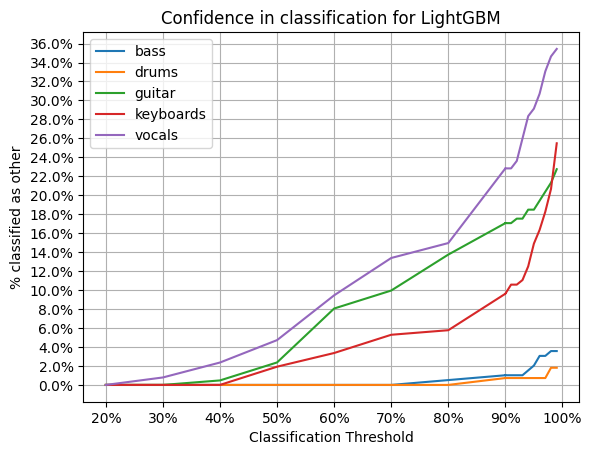

In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

x = np.concatenate([np.arange(0.2, 1, 0.1), np.arange(0.9, 1, 0.01)])

for i in range(perc_of_other.shape[1]):
    plt.plot(x, perc_of_other[:, i])

plt.legend(data.labels, loc='upper left')
plt.xlabel('Classification Threshold')
plt.ylabel('% classified as other')
plt.title('Confidence in classification for LightGBM')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.yticks(np.arange(0, np.max(perc_of_other)+0.02, 0.02))
plt.grid(visible=True)

plt.show()

In [9]:
dist = []
probs = lgbmc.predict_proba(X_test)
for i, t in enumerate(lgbmc.le.transform(y_test)):
    dist.append([probs[i][t], y_test[i], data.X_test[['filename']].iloc[i]])

In [10]:
import pandas as pd
df = pd.DataFrame(dist, columns=['prob', 'label', 'filename'])

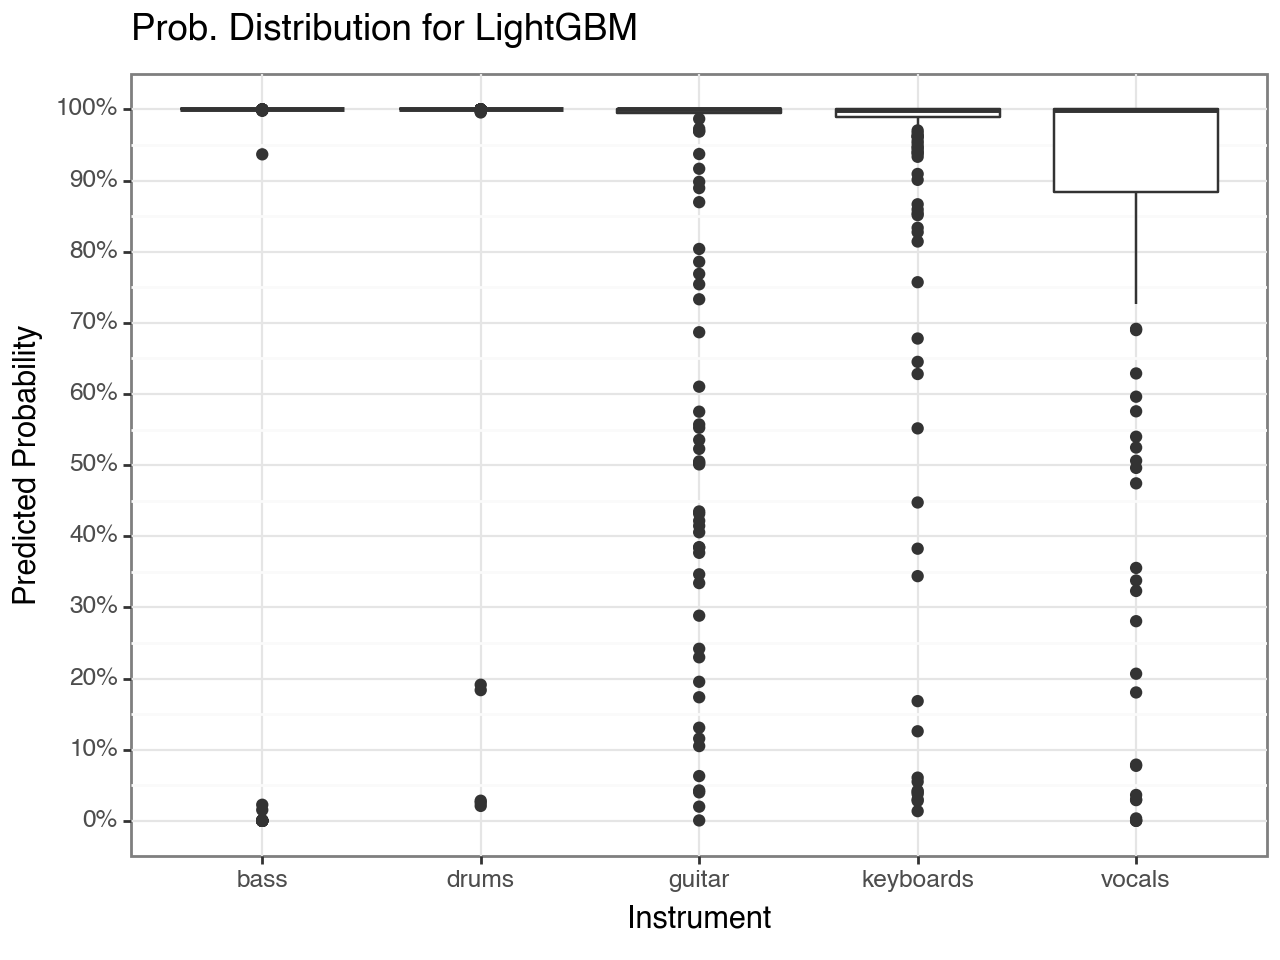

<Figure Size: (640 x 480)>

In [11]:
from plotnine import *
from mizani.formatters import percent_format
(
    ggplot(df) +
        aes(x = 'label', y = 'prob', group='label') + 
        geom_boxplot() + 
        theme_bw() + 
        scale_y_continuous(breaks = np.arange(0, 1.1, 0.1), labels = percent_format()) + 
        labs(x = "Instrument", y = "Predicted Probability", title = "Prob. Distribution for LightGBM")
)

In [12]:
df_proba = pd.DataFrame(np.concatenate([lgbmc.predict_proba(X_test), y_test.reshape((y_test.shape[0], 1))], axis=1), columns=list(data.labels) + ['label'])

In [13]:
df_proba

,bass,drums,guitar,keyboards,vocals,label
0,0.000002,0.999996,0.0,0.0,0.000002,drums
1,0.000002,0.999996,0.0,0.0,0.000001,drums
2,0.000011,0.999988,0.0,0.0,0.0,drums
3,1.0,0.0,0.0,0.0,0.0,bass
4,0.999999,0.0,0.0,0.0,0.0,bass
...,...,...,...,...,...,...
1013,0.000009,0.999678,0.000298,0.000007,0.000008,drums
1014,0.000155,0.999017,0.000247,0.000199,0.000382,drums
1015,0.000017,0.999919,0.000033,0.000008,0.000023,drums
1016,0.0002,0.998869,0.00014,0.000101,0.00069,drums


In [14]:
dfs = []
for class_ in data.labels:
    df_aux = df_proba[[class_, 'label']]
    df_aux['probs_group'] = pd.cut(df_aux[class_], np.arange(0, 1.1, .1))

    df_left_1 = df_aux.groupby(['probs_group']).count().reset_index().drop(['label'], axis=1).rename({class_: 'bin_count'}, axis=1)
    df_left_2 = df_aux.groupby(['probs_group', 'label']).count().reset_index().rename({class_: f'{class_}_count'}, axis=1)
    df_left_2 = df_left_2[df_left_2['label'] == class_]
    df_left_2 = df_left_2.drop(['label'], axis=1)
    df_prop = pd.merge(df_left_2, df_left_1)
    df_prop['prop'] = (df_prop[f'{class_}_count']/df_prop['bin_count']).replace(to_replace=np.nan, value=0)

    df_mean = df_aux.drop(['label'], axis=1).groupby(['probs_group']).mean().reset_index().replace(to_replace=np.nan, value=0).rename({class_: 'mean'}, axis=1)

    df_merge = pd.merge(df_prop, df_mean).drop([f'{class_}_count', 'bin_count'], axis=1)
    df_merge['label'] = class_
    dfs.append(df_merge)

/var/folders/hl/vy76lw6n1_bb2m8_hcb9clhw0000gn/T/ipykernel_2311/63459201.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/hl/vy76lw6n1_bb2m8_hcb9clhw0000gn/T/ipykernel_2311/63459201.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/hl/vy76lw6n1_bb2m8_hcb9clhw0000gn/T/ipykernel_2311/63459201.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [15]:
dfs = pd.concat(dfs)
dfs['mean'] = np.float64(dfs['mean'])

In [16]:
dfs

,probs_group,prop,mean,label
0,"(0.0, 0.1]",0.017348,0.001203,bass
1,"(0.1, 0.2]",0.000000,0.127372,bass
2,"(0.2, 0.3]",0.000000,0.230157,bass
3,"(0.3, 0.4]",0.000000,0.335422,bass
4,"(0.4, 0.5]",0.000000,0.451437,bass
5,"(0.5, 0.6]",0.000000,0.555325,bass
6,"(0.6, 0.7]",0.000000,0.000000,bass
7,"(0.7, 0.8]",0.000000,0.725820,bass
8,"(0.8, 0.9]",0.000000,0.828220,bass
9,"(0.9, 1.0]",0.973262,0.999205,bass


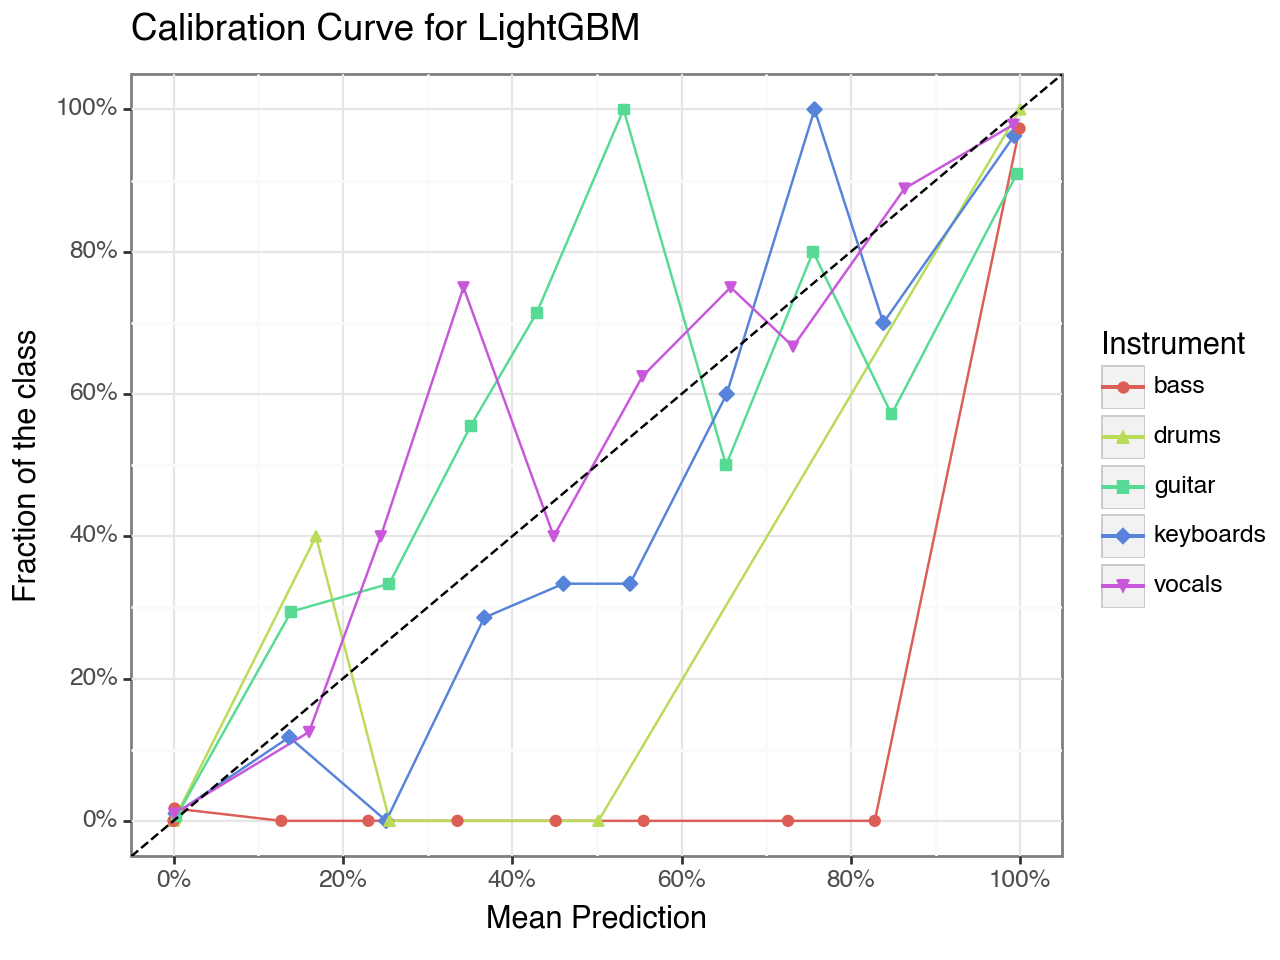

<Figure Size: (640 x 480)>

In [17]:
from plotnine import *
from mizani.formatters import percent_format
(
    ggplot(dfs) +
        aes(x = 'mean', y = 'prop', color='label', shape='label') +
        geom_line() +
        geom_point() +
        geom_abline(slope = 1, linetype='dashed') +
        theme_bw() + 
        scale_y_continuous(breaks = np.arange(0, 1.1, 0.2), labels = percent_format()) + 
        scale_x_continuous(breaks = np.arange(0, 1.1, 0.2), labels = percent_format()) + 
        labs(x = "Mean Prediction", y = "Fraction of the class", title = "Calibration Curve for LightGBM", color='Instrument', shape='Instrument')
)